In [ ]:
!pip install kaggle

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=e578385957b76925563d10b98e28f85c074933f0f88442ae6d75ccc67dceaf44
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [1]:
# need to be done once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# need to be done once
# on Kaggle in the Profil go to Edit Profil, then download API Token and upload here, will be saved in Drive then
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset to big
#!kaggle competitions download -c siim-isic-melanoma-classification

In [5]:
# found a new dataset which is already resized to 300x300 and 640x640
!kaggle datasets download bitthal/resize-jpg-siimisic-melanoma-classification
!unzip /content/resize-jpg-siimisic-melanoma-classification.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: 640x640/train/ISIC_8512716.jpg  
  inflating: 640x640/train/ISIC_8513112.jpg  
  inflating: 640x640/train/ISIC_8513649.jpg  
  inflating: 640x640/train/ISIC_8514170.jpg  
  inflating: 640x640/train/ISIC_8514989.jpg  
  inflating: 640x640/train/ISIC_8515165.jpg  
  inflating: 640x640/train/ISIC_8515281.jpg  
  inflating: 640x640/train/ISIC_8515582.jpg  
  inflating: 640x640/train/ISIC_8515674.jpg  
  inflating: 640x640/train/ISIC_8516181.jpg  
  inflating: 640x640/train/ISIC_8516223.jpg  
  inflating: 640x640/train/ISIC_8516516.jpg  
  inflating: 640x640/train/ISIC_8516631.jpg  
  inflating: 640x640/train/ISIC_8516659.jpg  
  inflating: 640x640/train/ISIC_8516922.jpg  
  inflating: 640x640/train/ISIC_8517305.jpg  
  inflating: 640x640/train/ISIC_8517492.jpg  
  inflating: 640x640/train/ISIC_8518406.jpg  
  inflating: 640x640/train/ISIC_8519222.jpg  
  inflating: 640x640/train/ISIC_8519402.jpg  
  inflating: 

In [6]:
import numpy as np
import pandas as pd

# load and display an image with Matplotlib
from matplotlib import image
#from matplotlib import pyplot

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB4

import seaborn as sns

In [7]:
img_path = '/content/640x640/train/'

IMG_SIZE = 380

#NUM_CLASSES = 2

uint8
(640, 640, 3)


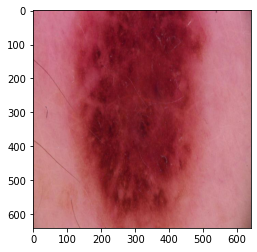

In [8]:
# load image as pixel array
image_test = image.imread(img_path + 'ISIC_9999806.jpg')
# summarize shape of the pixel array
print(image_test.dtype)
print(image_test.shape)
# display the array of pixels as an image
plt.imshow(image_test)
plt.show()

In [9]:
#train_csv = pd.read_csv('/content/drive/MyDrive/train.csv')
train_csv = pd.read_csv('/content/drive/MyDrive/TechLabs/ISIC_2020_Training_GroundTruth.csv')

#train_csv = pd.read_csv('train.csv')

In [10]:
print(train_csv.head())

     image_name  patient_id     sex  ...  diagnosis benign_malignant target
0  ISIC_2637011  IP_7279968    male  ...    unknown           benign      0
1  ISIC_0015719  IP_3075186  female  ...    unknown           benign      0
2  ISIC_0052212  IP_2842074  female  ...      nevus           benign      0
3  ISIC_0068279  IP_6890425  female  ...    unknown           benign      0
4  ISIC_0074268  IP_8723313  female  ...    unknown           benign      0

[5 rows x 8 columns]


In [11]:
train_csv['diagnosis'].unique()

array(['unknown', 'nevus', 'melanoma', 'seborrheic keratosis',
       'lentigo NOS', 'lichenoid keratosis', 'solar lentigo',
       'cafe-au-lait macule', 'atypical melanocytic proliferation'],
      dtype=object)

### test

In [12]:
# add path to image names for loading

train_data = []
for img in train_csv['image_name']:
  train_data.append(img_path + img + '.jpg')
len(train_data), train_data[0]

(33126, '/content/640x640/train/ISIC_2637011.jpg')

In [13]:
train_label = train_csv['target']
len(train_label), train_label[10]

(33126, 0)

In [14]:
# make new dataframe, only with images names and path

train_df = pd.DataFrame(train_data)
train_df.columns = ['image']
train_df['target'] = train_label

In [15]:
# split dataset into train set and validation set
# duplicate the 1-labeled images by factor

X_train, X_val, y_train, y_val = train_test_split(train_df['image'], train_df['target'], test_size=0.2)

factor = 5


lis = []
for index in X_train.index:
  if index in y_train.index and y_train[index] == 1:
    lis.append(X_train[index])
s_1 = pd.Series(lis, index=lis)
s_2 = pd.Series(1, index=lis)
for n in range(factor-1):
  X_train = X_train.append(s_1, ignore_index=True)
  y_train = y_train.append(s_2, ignore_index=True)

train_data = pd.DataFrame({'image': X_train, 'target': y_train})
val_data = pd.DataFrame({'image': X_val, 'target': y_val})

print(len(X_train))
n=0
for label in y_train:
  if label == 1:
    n= n+1
print(n)
print(1-n/len(X_train))

28340
2300
0.9188426252646436


In [16]:
# use tensorflow ImageDataGenerator to load images for input 
# from https://keras.io/api/preprocessing/image/#flow_from_dataframe-method

# train generator with augmentation (flips) and rescale, so that values are between 0 & 1
train_data_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, zoom_range=0.1,)

train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='image',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='raw',
    batch_size=20,
    shuffle=True
)

# validation generator with rescale, so that values are between 0 & 1
validation_data_gen = ImageDataGenerator()

validation_generator = validation_data_gen.flow_from_dataframe(
    val_data,
    x_col='image',
    y_col='target',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    class_mode='raw',
    batch_size=20,
    shuffle=False
)


Found 28340 validated image filenames.
Found 6626 validated image filenames.


next steps also from [keras.io](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) ->
Image classification via fine-tuning with EfficientNet

modified to binary classification with only two classes

In [26]:
effnet = EfficientNetB4(weights='imagenet', drop_connect_rate=0.4, include_top=False)

71688192/71686520 [==============================] - 0s 0us/step


In [38]:
#custom loss function
def custom_loss_function(y_true, y_pred):
   imbalanced_cross_entropy = -(15 * tf.multiply(tf.cast(y_true, tf.float32), tf.math.log(y_pred))+tf.multiply(tf.cast((1 - y_true), tf.float32),tf.math.log(1- y_pred)))
   return tf.reduce_mean(imbalanced_cross_entropy, axis=-1)

In [18]:
#"area under the curve" as metric function
my_metric_fn = tf.keras.metrics.AUC(
    num_thresholds=200, curve='ROC',
    summation_method='interpolation', name=None, dtype=None,
    thresholds=None, multi_label=False, label_weights=None
    )

#def my_metric_fn(y_true, y_pred):
#    false_negatives = tf.reduce_mean(tf.cast(y_true, tf.float32) * tf.cast(tf.math.greater(0.3,y_pred), tf.float32), axis=-1)
#    false_positives = tf.reduce_mean(tf.cast(1- y_true, tf.float32)* tf.cast(tf.math.greater(y_pred, 0.3), tf.float32), axis=-1)
#    return false_negatives

In [19]:
from tensorflow.keras import layers

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB4(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    #changed softmax to sigmoid because of binary classification
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss=custom_loss_function, metrics=[my_metric_fn]
    )
    return model

In [25]:
model = build_model(1)

In [21]:
def plot_hist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Epoch 1/2
1417/1417 [==============================] - 1160s 789ms/step - loss: 1.5754 - auc: 0.6735 - val_loss: 0.8016 - val_auc: 0.8250
Epoch 2/2
1417/1417 [==============================] - 1096s 773ms/step - loss: 1.3156 - auc: 0.7629 - val_loss: 0.7987 - val_auc: 0.8375


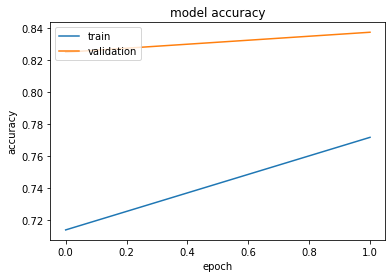

In [27]:
EPOCHS = 2


hist = model.fit(
    x=train_generator, epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator)
plot_hist(hist)

next steps: 

unfreeze model and retrain


In [35]:
def unfreeze_model(model):
    # We unfreeze the top 70 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-100:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss=custom_loss_function, metrics=[my_metric_fn]
    )


unfreeze_model(model)

In [ ]:
model.summary()

Epoch 1/3
1417/1417 [==============================] - 1178s 822ms/step - loss: 1.1773 - auc: 0.8128 - val_loss: 0.7708 - val_auc: 0.8660
Epoch 2/3
1417/1417 [==============================] - 1157s 816ms/step - loss: 1.0335 - auc: 0.8576 - val_loss: 0.8108 - val_auc: 0.8743
Epoch 3/3
1417/1417 [==============================] - 1152s 813ms/step - loss: 0.8937 - auc: 0.8906 - val_loss: 0.7102 - val_auc: 0.8824


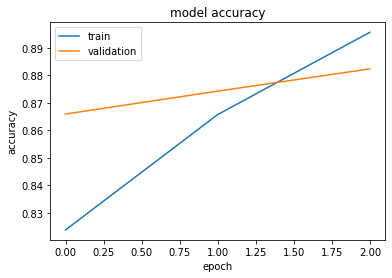

In [29]:
EPOCHS = 3


hist = model.fit(
    x=train_generator, epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator)
plot_hist(hist)

1417/1417 [==============================] - 1167s 824ms/step - loss: 0.7820 - auc: 0.9176 - val_loss: 0.5783 - val_auc: 0.8790


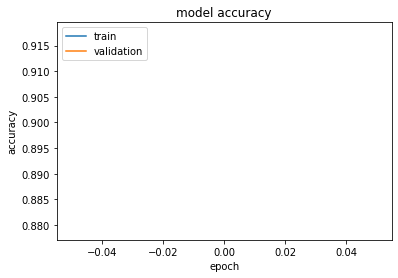

In [31]:
EPOCHS = 1


hist = model.fit(
    x=train_generator, epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator)
plot_hist(hist)

1417/1417 [==============================] - 1166s 823ms/step - loss: 0.7116 - auc: 0.9327 - val_loss: 0.5438 - val_auc: 0.8814


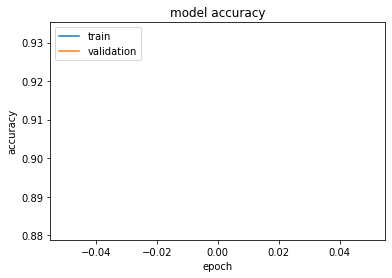

In [32]:
EPOCHS = 1


hist = model.fit(
    x=train_generator, epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator)
plot_hist(hist)

In [ ]:
EPOCHS = 5


hist = model.fit(
    x=train_generator, epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator)
plot_hist(hist)

In [ ]:
#saving model
model.save('/content/drive/MyDrive/')

In [ ]:
#loading model
model2=tf.keras.models.load_model('/content/drive/MyDrive/')

In [ ]:
model2=model

In [ ]:
from keras.preprocessing import image

In [ ]:
#prepare picture for prediction
img = image.load_img((img_path + 'ISIC_0333091.jpg'), target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

#make prediction
images = np.vstack([x])
classes = np.argmax(model2.predict(images, batch_size=None), axis=1)
print(classes)

[0]


In [ ]:
#make prediction for all pictures in validation dataset
y_pred = model2.predict(validation_generator)
# floor of predictions
edge = 0.5
y_pred = tf.cast(tf.math.floor(y_pred+ (1-edge)), tf.int64)
print(y_pred[0:10])

tf.Tensor(
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]], shape=(10, 1), dtype=int64)


In [ ]:
#construct confusion matrix
con_mat = tf.math.confusion_matrix(labels=y_val, predictions=y_pred).numpy()

In [ ]:
#edit confusion matrix for plotting
classes = [0,1]
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

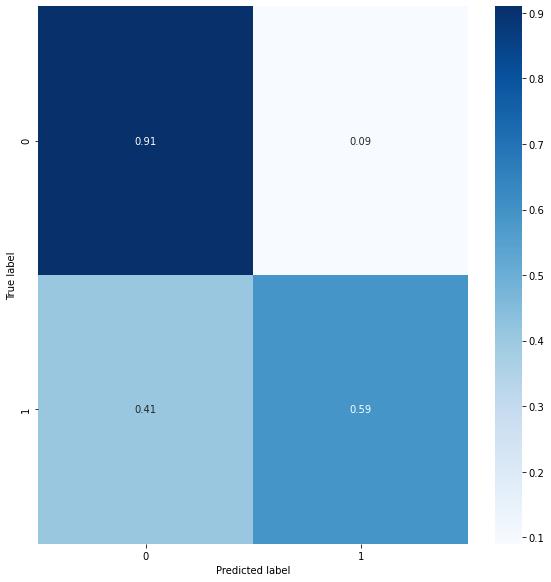

In [ ]:
#plot confusion matrix
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#count how many pictures of non-cancerous(0) and cancerous(1) moles we have --> 98% are non-cancerous
print(train_df["target"].value_counts())

0    32542
1      584
Name: target, dtype: int64
